<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/Model_Reducing_Commercial_Aviation_Fatalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinando Modelo - Reduzindo Fatalidades na Aviação Comercial

## Importando bibliotecas utilizadas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

IN_COLAB = 'google.colab' in sys.modules

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Montando google drive caso esteja executando no google colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
competition_name = 'reducing-commercial-aviation-fatalities'
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/{competition_name}'
tcc_dir = '/gdrive/My Drive/Pos Graduação/TCC'
mlflow_dir = f'{tcc_dir}/mlruns'
h20_models = f'{tcc_dir}/automl'
mlflow_models_path = f'{tcc_dir}/models'

## Carregando os dados

In [0]:
if IN_COLAB and not os.path.exists(competition_name):
    !cp -r '{data_gdrive_dir}' .

In [0]:
eeg_columns = ['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 
               'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3', 
               'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',	'eeg_c4', 
               'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2']

numeric_features = [*eeg_columns, 'ecg', 'r', 'gsr']
categorical_features = ['event']

In [0]:
# Realizando a leitura dos dados salvos após a limpeza
train_df = pd.read_parquet(f'{competition_name}/train_balanced.parquet')

In [8]:
train_df.head()

,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,-0.792237,0.831934,-9.429030,-4.17883,-1.58939,5.67909,1.763630,-2.098780,2.96651,1.44328,-3.94931,-2.22939,-4.573080,-8.084340,-8.46484,-4.68844,-4.750770,-2.04203,-4.60896,1.837780,9322.370117,815.594971,0.000000,A
1,5.937200,5.026230,-0.933735,-1.19951,4.79854,-1.96581,1.134890,4.274110,2.21295,4.60106,1.61440,5.25442,4.693770,2.867810,2.75299,8.24299,0.721092,3.08044,4.83091,3.794880,5931.060059,830.568970,1453.670044,A
2,-1.162280,0.260127,-5.989480,-3.46853,-3.87440,3.96828,0.728967,-4.655380,1.64105,-1.29032,-5.34865,-1.59114,-0.350429,-1.959580,-1.04339,-3.01729,-2.019750,-2.43368,-2.89067,-0.602369,9320.519531,815.533997,0.000000,A
3,-10.467600,-8.344960,-4.106620,-3.58671,-5.99199,-6.09401,-8.098010,-13.164800,-8.42648,-8.25574,-8.85742,-8.31783,-10.007400,-4.956020,-6.94528,-10.07500,-9.700760,-6.47439,-5.58930,-10.150300,9293.780273,816.421997,0.000000,A
4,-15.538500,-4.782070,-25.117800,-14.71600,-14.40480,-5.53229,-0.526621,-34.102798,-7.38440,-3.33520,-7.56394,-11.75630,-15.780400,-25.708401,-13.23830,-13.04150,-5.686500,-2.66797,-3.96213,-9.862170,8765.589844,814.518982,0.000000,A


In [9]:
print(f'Quantidade de entradas: {train_df.shape[0]}')

Quantidade de entradas: 522232


In [0]:
features = numeric_features
target = 'event'

## Separando os dados de Treinamento/Validação e Testes

In [0]:
# Separando os dados balanceados de treinamento/validação e testes
balanced_X_train, balanced_X_test, balanced_y_train, balanced_y_test = train_test_split(
    train_df[features], train_df[target], test_size=0.20, random_state=42)

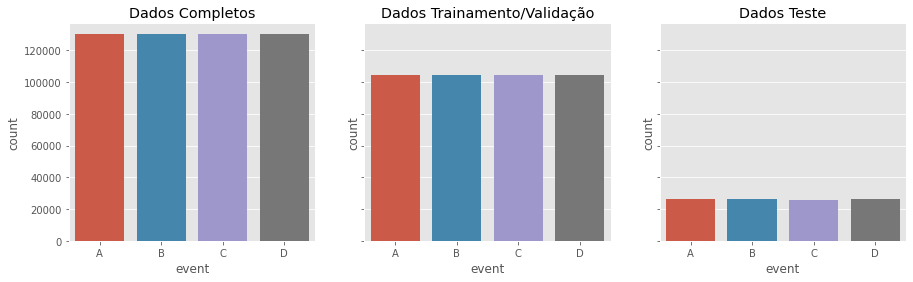

In [12]:
# Visualizando a separação dos dados
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

order = ['A', 'B', 'C', 'D']
sns.countplot(train_df[target], order=order, ax=ax[0]).set_title('Dados Completos');
sns.countplot(balanced_y_train, order=order, ax=ax[1]).set_title('Dados Trainamento/Validação');
sns.countplot(balanced_y_test, order=order, ax=ax[2]).set_title('Dados Teste');

## Importando bibliotecas dos modelos utilizados

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

### Importando/Instalando MLFlow

In [14]:
# Importando bibliotecas necessárias (instalando no colab, pois esse pacote não é instalado por default)
if IN_COLAB:
    !pip install -q -U mlflow
import mlflow
import mlflow.sklearn

if IN_COLAB:
    mlflow.set_tracking_uri(f'{mlflow_dir}')

     |████████████████████████████████| 16.0MB 308kB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 153kB 62.2MB/s 
     |████████████████████████████████| 460kB 47.3MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
     |████████████████████████████████| 6.0MB 26.8MB/s 
     |████████████████████████████████| 1.1MB 46.4MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 204kB 55.7MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 


### Importando/Instalando h20

In [0]:
if IN_COLAB:
    !pip install -q h2o

import h2o
from h2o.automl import H2OAutoML, get_leaderboard

## Avaliando melhores modelos com GridSearch e CrossValidation

In [15]:
# Definição do Pipeline
pipe = Pipeline([('classifier', RandomForestClassifier())])

# Definição do espaço de busca
search_space = [{'classifier': [LogisticRegression()]},
                {'classifier': [DecisionTreeClassifier()]},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [50, 100, 200]},
                {'classifier': [lgb.LGBMClassifier()],
                 'classifier__n_estimators': [100, 200]}]

# Inicialização do GridSearchCV
grid_clf = GridSearchCV(pipe, search_space, cv=5, 
                        verbose=10, n_jobs=-1, 
                        scoring=['accuracy', 
                                 'f1_macro', 
                                 'neg_log_loss'], 
                        refit='neg_log_loss')

# Execução/Treinamento
best_model = grid_clf.fit(balanced_X_train, balanced_y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  35 | elapsed:   33.9s remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   8 out of  35 | elapsed:   34.7s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:   56.6s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:  1.5min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:  1.6min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:  3.3min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:  5.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed: 10.7min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 11.0min finished


In [16]:
grid_search_result_df = pd.DataFrame(
    best_model.cv_results_).sort_values('rank_test_neg_log_loss')
grid_search_result_df.to_excel('grid_search_result.xlsx')
grid_search_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
4,633.618697,5.795493,11.552373,0.028079,"RandomForestClassifier(bootstrap=True, ccp_alp...",200,{'classifier': RandomForestClassifier(bootstra...,0.973742,0.973288,0.974137,0.973264,0.973228,0.973532,0.000356,1,0.973690,0.973249,0.974103,0.973212,0.973177,0.973486,0.000360,1,-0.134448,-0.136491,-0.135835,-0.135104,-0.135105,-0.135396,0.000701,1
3,341.809483,11.240088,6.379347,0.062299,"RandomForestClassifier(bootstrap=True, ccp_alp...",100,{'classifier': RandomForestClassifier(bootstra...,0.973336,0.972677,0.973886,0.973216,0.973156,0.973254,0.000387,3,0.973282,0.972643,0.973856,0.973176,0.973114,0.973214,0.000389,3,-0.135150,-0.137730,-0.133838,-0.134412,-0.136153,-0.135457,0.001375,2
6,77.845211,2.968557,13.055227,0.115050,"LGBMClassifier(boosting_type='gbdt', class_wei...",200,{'classifier': LGBMClassifier(boosting_type='g...,0.951530,0.951518,0.953110,0.951674,0.951434,0.951853,0.000633,5,0.951446,0.951502,0.953108,0.951610,0.951378,0.951809,0.000654,5,-0.134732,-0.137452,-0.135006,-0.135125,-0.136642,-0.135791,0.001064,3
2,187.488320,5.710254,3.761484,0.081524,"RandomForestClassifier(bootstrap=True, ccp_alp...",50,{'classifier': RandomForestClassifier(bootstra...,0.972510,0.972235,0.972450,0.971576,0.972689,0.972292,0.000386,4,0.972470,0.972206,0.972421,0.971535,0.972647,0.972256,0.000387,4,-0.137106,-0.138244,-0.138458,-0.140636,-0.136228,-0.138134,0.001488,4
5,46.788734,1.281174,6.619330,0.038590,"LGBMClassifier(boosting_type='gbdt', class_wei...",100,{'classifier': LGBMClassifier(boosting_type='g...,0.937982,0.936810,0.939036,0.938150,0.938473,0.938090,0.000734,6,0.937879,0.936748,0.939014,0.938051,0.938396,0.938018,0.000744,6,-0.172515,-0.175619,-0.172192,-0.172976,-0.173945,-0.173450,0.001235,5
1,31.167164,0.691303,1.827406,0.009216,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,{'classifier': DecisionTreeClassifier(ccp_alph...,0.974963,0.972426,0.973000,0.972881,0.973970,0.973448,0.000909,2,0.974956,0.972428,0.972996,0.972871,0.973956,0.973441,0.000906,2,-0.864740,-0.952372,-0.932531,-0.936664,-0.899049,-0.917071,0.031408,6
0,28.900620,4.088861,1.678982,0.282991,"LogisticRegression(C=1.0, class_weight=None, d...",NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.396747,0.398291,0.395646,0.400014,0.400984,0.398336,0.001979,7,0.376654,0.378667,0.376939,0.379422,0.379973,0.378331,0.001323,7,-1.295972,-1.295375,-1.296191,-1.294007,-1.293594,-1.295028,0.001045,7


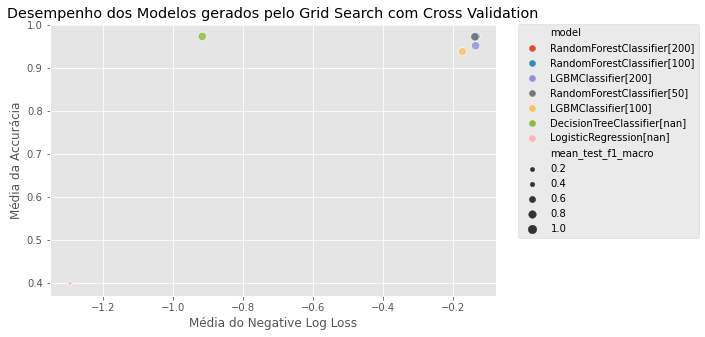

In [17]:
grid_search_result_df['model'] = grid_search_result_df.param_classifier.astype(str).str.split('(').apply(lambda x: x[0]) + '[' + grid_search_result_df.param_classifier__n_estimators.astype(str) + ']'

plt.figure(figsize=(8, 5))
sns.scatterplot(x="mean_test_neg_log_loss", y="mean_test_accuracy",
                     hue="model", size="mean_test_f1_macro", alpha=0.8,
                     data=grid_search_result_df).set_title('Desempenho dos Modelos gerados pelo Grid Search com Cross Validation');
plt.xlabel("Média do Negative Log Loss")
plt.ylabel("Média da Accurácia")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Avaliando modelos separadamente

### Definindo função para exibição dos resultados e métricas

Foi utilizado o MLFlow para rastrear todas as rodadas de testes isolados

In [0]:
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, classification_report, log_loss, f1_score, accuracy_score

def show_metrics(model, X_test, y_test, run_name, experiment_name='TCC', sklearn_model=True):
    """Função para mostrar as métricas e salvá-las no ML Flow"""
    # Define o experimento
    mlflow.set_experiment(experiment_name)

    if sklearn_model:
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax[0])
        ax[0].set_title('Matrix Confusão, sem normalização')

        plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax[1])
        ax[1].set_title('Matrix Confusão Normalizada')

        plt.tight_layout()
        plt.show()

        y_predict = model.predict(X_test)
        y_predict_prob = model.predict_proba(X_test)
    else:
        prediction = model.predict(h2o.H2OFrame(X_test)).as_data_frame()
        y_predict = prediction['predict']
        y_predict_prob = prediction.drop('predict', axis=1)

    logloss = log_loss(y_test, y_predict_prob)
    f1 = f1_score(y_test, y_predict, average='macro')

    with mlflow.start_run(run_name=run_name):
        if sklearn_model:
            mlflow.log_param("model_description", str(model))
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("log_loss", logloss)
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_predict))
        if not IN_COLAB:
            mlflow.sklearn.log_model(model, "model")
            mlflow.sklearn.save_model(model, mlflow_models_path)

    display(pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T)
    print(f'\nLog loss: {logloss} | F1 Score: {f1}')

### Analisando desempenho do modelo de Regressão Logística

In [0]:
# Foi realizada uma normalização das colunas numéricas no pipeline desse modelo,
# devido a sua sensibilidade na variação no range das colunas, e essa variação
# impacta no desempenho do modelo

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

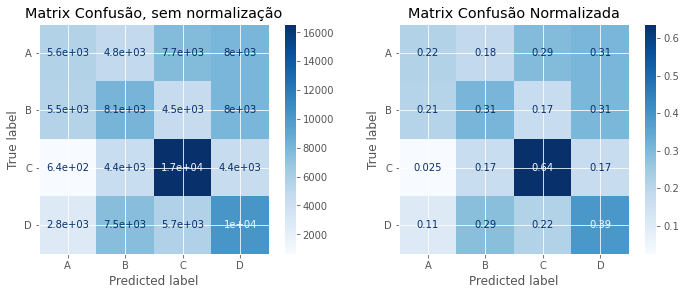

,precision,recall,f1-score,support
A,0.386786,0.215416,0.276718,26089.000000
B,0.329024,0.311232,0.319881,26167.000000
C,0.481164,0.637850,0.548538,25992.000000
D,0.334137,0.391656,0.360617,26199.000000
accuracy,0.388752,0.388752,0.388752,0.388752
macro avg,0.382778,0.389039,0.376438,104447.000000
weighted avg,0.382595,0.388752,0.376220,104447.000000



Log loss: 1.2794922338334827 | F1 Score: 0.37643827732281887


In [0]:
from sklearn.linear_model import LogisticRegression

LR_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(n_jobs=-1))])

LR_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(LR_clf, balanced_X_test, balanced_y_test, 'LogisticRegression')

### Analisando desempenho do modelo de Árvore de Decisão

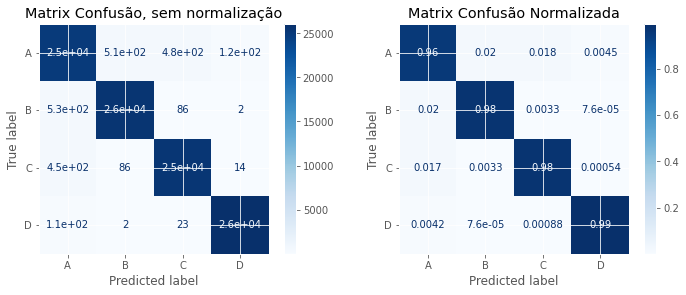

,precision,recall,f1-score,support
A,0.958407,0.957415,0.957911,26089.000000
B,0.977020,0.976497,0.976758,26167.000000
C,0.977377,0.978994,0.978184,25992.000000
D,0.994885,0.994809,0.994847,26199.000000
accuracy,0.976945,0.976945,0.976945,0.976945
macro avg,0.976922,0.976929,0.976925,104447.000000
weighted avg,0.976941,0.976945,0.976943,104447.000000



Log loss: 0.7962830292774825 | F1 Score: 0.9769251078398671


In [0]:
from sklearn.tree import DecisionTreeClassifier

DT_clf = DecisionTreeClassifier()
DT_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(DT_clf, balanced_X_test, balanced_y_test, 'DecisionTreeClassifier')

### Analisando desempenho do modelo de Random Forest

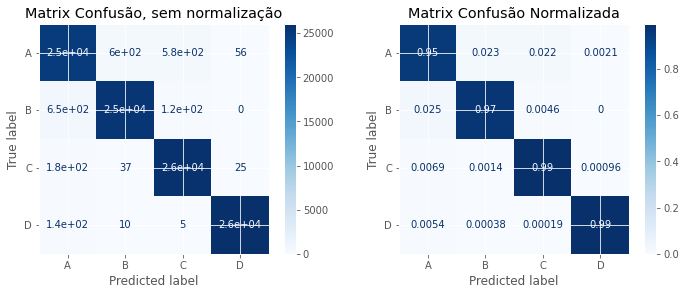

,precision,recall,f1-score,support
A,0.962428,0.952394,0.957385,26089.000000
B,0.975083,0.970574,0.972823,26167.000000
C,0.973168,0.990728,0.981869,25992.000000
D,0.996899,0.994007,0.995451,26199.000000
accuracy,0.976926,0.976926,0.976926,0.976926
macro avg,0.976894,0.976926,0.976882,104447.000000
weighted avg,0.976918,0.976926,0.976894,104447.000000



Log loss: 0.1250277326022333 | F1 Score: 0.9768820225842627


In [18]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
RF_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(RF_clf, balanced_X_test, balanced_y_test, 'RandomForestClassifier')

### Analisando desempenho do modelo LightGBM

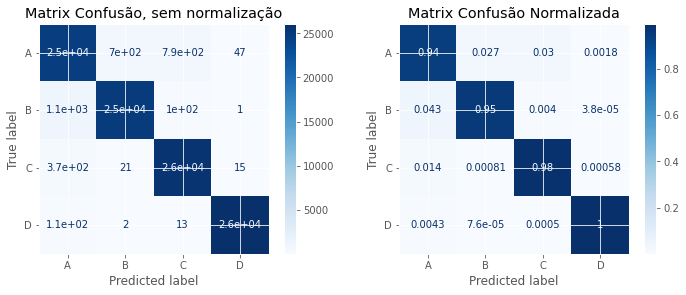

,precision,recall,f1-score,support
A,0.938779,0.941010,0.939893,26089.000000
B,0.971721,0.953376,0.962461,26167.000000
C,0.965797,0.984264,0.974943,25992.000000
D,0.997589,0.995114,0.996350,26199.000000
accuracy,0.968443,0.968443,0.968443,0.968443
macro avg,0.968472,0.968441,0.968412,104447.000000
weighted avg,0.968507,0.968443,0.968431,104447.000000



Log loss: 0.0937984349415199 | F1 Score: 0.9684119575615247


In [0]:
import lightgbm as lgb

lgbm_clf = lgb.LGBMClassifier(n_estimators=500)
lgbm_clf.fit(balanced_X_train, balanced_y_train, eval_metric='logloss')

show_metrics(lgbm_clf, balanced_X_test, balanced_y_test, 'LGBMClassifier')

## Gerando modelo final do melhor modelo encontrado

In [0]:
# Gerando modelo final com todos os dados de treinamento
RF_clf = RF_clf.fit(train_df[features], train_df[target])

### Prevendo dados de teste

In [0]:
def predict_proba_test(model, nrows=None, sklearn_model=True, chunksize=100_000):
    test_df = pd.read_csv(f'{competition_name}/test.csv.zip', 
                          usecols=features, nrows=nrows, chunksize=chunksize)
    predict_results = []
    for test_chunk in tqdm(test_df):
        if sklearn_model:
            predict_results.append(
                pd.DataFrame(
                    model.predict_proba(test_chunk), columns=model.classes_))
        else:
            predict_results.append(
                model.predict(
                    h2o.H2OFrame(test_chunk))
                .as_data_frame().drop('predict', axis=1).reset_index())
    return pd.concat(predict_results, ignore_index=True).reset_index().rename(columns={'index': 'id'})

In [88]:
sample_test_result_df = predict_proba_test(RF_clf, 10_000)
sample_test_result_df.head()

,id,A,B,C,D
0,0,0.094,0.634,0.052,0.220
1,1,0.118,0.524,0.082,0.276
2,2,0.050,0.684,0.058,0.208
3,3,0.132,0.494,0.096,0.278
4,4,0.114,0.624,0.060,0.202


### Submetendo dados para o Kaggle

In [0]:
# Obtendo as credenciais armazenadas para submissão dos dados
def get_kaggle_json(api_location):
    api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')
    if not os.path.exists(api_local_credential_location):
        !mkdir -p ~/.kaggle
        !cp '{api_location}' '{api_local_credential_location}'

if IN_COLAB:
    get_kaggle_json(api_gdrive_credential_location)

In [0]:
def submit_result_kaggle(model, comment='', sklearn_model=True, chunksize=100_000, only_submit=False):
    if not only_submit:
        test_result_df = predict_proba_test(model, sklearn_model=sklearn_model, chunksize=chunksize)
        test_result_df.to_csv('test_result.csv', index=False)
    !kaggle competitions submit -c reducing-commercial-aviation-fatalities -f test_result.csv -m "{comment}"

In [98]:
submit_result_kaggle(RF_clf, "Submit best random forest model estimators=500")


100% 540M/540M [00:08<00:00, 67.9MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

## Obtendo modelos utilizando a ferramenta de autoML H2O

In [16]:
# Iniciando cluester h20
h2o.init()

     |████████████████████████████████| 129.5MB 30kB/s 
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpeg73o6gp
  JVM stdout: /tmp/tmpeg73o6gp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpeg73o6gp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_unknownUser_2jhlmt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.379 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [106]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=10, max_runtime_secs=6000, max_runtime_secs_per_model=600, sort_metric='logloss')
aml.train(x=features, y=target, training_frame=h2o.H2OFrame(pd.concat([balanced_X_train, balanced_y_train], axis=1)))

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [107]:
lb = get_leaderboard(aml, extra_columns='ALL')
lb.head(rows=lb.nrows)

model_id,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
GBM_grid__1_AutoML_20200410_150537_model_1,0.0212255,0.00705106,0.0744785,0.00554704,101030,0.017959
XGBoost_grid__1_AutoML_20200410_150537_model_1,0.0301429,0.0100331,0.0889327,0.00790902,142137,0.002116
StackedEnsemble_AllModels_AutoML_20200410_150537,0.0307664,0.00785281,0.0815859,0.00665625,294329,0.117313
StackedEnsemble_BestOfFamily_AutoML_20200410_150537,0.0309271,0.0075106,0.0800303,0.00640484,87168,0.029142
XGBoost_2_AutoML_20200410_150537,0.0604786,0.0175883,0.124791,0.0155728,47715,0.00096
GBM_4_AutoML_20200410_150537,0.0715908,0.0210533,0.137033,0.018778,24462,0.012733
GBM_5_AutoML_20200410_150537,0.0732891,0.0223669,0.140079,0.0196221,24719,0.007523
XGBoost_grid__1_AutoML_20200410_150537_model_3,0.0867899,0.0269786,0.152798,0.0233472,111135,0.002437
GBM_3_AutoML_20200410_150537,0.0946541,0.0293517,0.160261,0.0256835,24662,0.009836
XGBoost_grid__1_AutoML_20200410_150537_model_2,0.0988431,0.0319602,0.16486,0.0271789,127033,0.003186


In [108]:
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20200410_150537_model_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,136.0,544.0,34539220.0,16.0,16.0,16.0,746.0,8760.0,5058.3916




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 2.9175181985310367e-07
RMSE: 0.0005401405556455687
LogLoss: 0.000182198793627346
Mean Per-Class Error: 0.0

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,A,B,C,D,Error,Rate
0,104469.0,0.0,0.0,0.0,0.0,"0 / 104,469"
1,0.0,104391.0,0.0,0.0,0.0,"0 / 104,391"
2,0.0,0.0,104566.0,0.0,0.0,"0 / 104,566"
3,0.0,0.0,0.0,104359.0,0.0,"0 / 104,359"
4,104469.0,104391.0,104566.0,104359.0,0.0,"0 / 417,785"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0



ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.0055470402069107885
RMSE: 0.07447845464905128
LogLoss: 0.02122546272372881
Mean Per-Class Error: 0.007051059136918395

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,A,B,C,D,Error,Rate
0,102827.0,543.0,1038.0,61.0,0.015718,"1,642 / 104,469"
1,607.0,103621.0,163.0,0.0,0.007376,"770 / 104,391"
2,296.0,27.0,104228.0,15.0,0.003232,"338 / 104,566"
3,193.0,0.0,3.0,104163.0,0.001878,"196 / 104,359"
4,103923.0,104191.0,105432.0,104239.0,0.007051,"2,946 / 417,785"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.992949
1,2,0.999691
2,3,0.999993
3,4,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.99294853,3.7133222E-4,0.992544,0.9931065,0.9928672,0.9927235,0.9935014
1,err,0.007051474,3.7133222E-4,0.0074559883,0.006893498,0.0071328552,0.00727647,0.006498558
2,err_count,589.2,31.027407,623.0,576.0,596.0,608.0,543.0
3,logloss,0.021225464,4.2718608E-4,0.021581408,0.021050563,0.021197747,0.021678014,0.02061958
4,max_per_class_error,0.015718298,0.0012825482,0.01644768,0.015762499,0.015426759,0.01718675,0.013767805
5,mean_per_class_accuracy,0.9929485,3.6570214E-4,0.9925786,0.99308,0.99285233,0.99271834,0.993513
6,mean_per_class_error,0.007051546,3.6570214E-4,0.007421365,0.006919982,0.0071476847,0.007281668,0.00648703
7,mse,0.00554704,2.0310882E-4,0.0057663093,0.0054638777,0.0056182467,0.0056476607,0.0052391067
8,r2,0.9955613,1.5987207E-4,0.9954006,0.99561906,0.9955055,0.99547124,0.99581003
9,rmse,0.07446837,0.0013706186,0.07593622,0.073918045,0.074954964,0.075150914,0.072381675



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
0,,2020-04-10 16:11:30,7 min 30.710 sec,0.0,0.750000,1.386294,0.749852
1,,2020-04-10 16:11:33,7 min 33.795 sec,5.0,0.461403,0.620243,0.035037
2,,2020-04-10 16:11:37,7 min 37.341 sec,10.0,0.312398,0.364005,0.025745
3,,2020-04-10 16:11:41,7 min 41.065 sec,15.0,0.220699,0.223831,0.020324
4,,2020-04-10 16:11:45,7 min 44.990 sec,20.0,0.171520,0.151190,0.015314
5,,2020-04-10 16:11:48,7 min 48.777 sec,25.0,0.133352,0.100140,0.010379
6,,2020-04-10 16:11:52,7 min 52.746 sec,30.0,0.104721,0.065022,0.006625
7,,2020-04-10 16:11:56,7 min 56.759 sec,35.0,0.084826,0.044570,0.003945
8,,2020-04-10 16:12:00,8 min 0.535 sec,40.0,0.069586,0.033010,0.002090
9,,2020-04-10 16:12:04,8 min 4.502 sec,45.0,0.054873,0.023765,0.000910



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,r,503249.343750,1.000000,0.366682
1,ecg,415689.406250,0.826011,0.302883
2,gsr,259823.296875,0.516291,0.189315
3,eeg_fp1,25491.021484,0.050653,0.018573
4,eeg_fp2,21492.316406,0.042707,0.015660
5,eeg_f8,21220.755859,0.042167,0.015462
6,eeg_f3,20595.017578,0.040924,0.015006
7,eeg_f7,19986.548828,0.039715,0.014563
8,eeg_t3,9712.585938,0.019300,0.007077
9,eeg_c4,8576.305664,0.017042,0.006249



See the whole table with table.as_data_frame()


In [110]:
show_metrics(aml.leader, balanced_X_test, balanced_y_test, 'H2O Automl GBM', sklearn_model=False)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


,precision,recall,f1-score,support
A,0.991991,0.987466,0.989723,26089.000000
B,0.995255,0.994000,0.994627,26167.000000
C,0.990753,0.997538,0.994134,25992.000000
D,0.999618,0.998626,0.999122,26199.000000
accuracy,0.994409,0.994409,0.994409,0.994409
macro avg,0.994404,0.994407,0.994401,104447.000000
weighted avg,0.994414,0.994409,0.994407,104447.000000



Log loss: 0.016344507082644198 | F1 Score: 0.9944014452613698


### Retreinando melhor modelo h20 com todos os dados disponíveis

In [18]:
h20_model.train(x=features, y=target, training_frame=h2o.H2OFrame(pd.concat([train_df[features], train_df[target]], axis=1)))

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
# Salvando modelo final
h2o.save_model(model=aml.leader, path=h20_models, force=True)

'/gdrive/My Drive/Pos Graduação/TCC/automl/GBM_model_python_1586538302325_1'

### Submetendo dados para o Kaggle

In [0]:
h20_model = h2o.load_model('/gdrive/My Drive/Pos Graduação/TCC/automl/GBM_model_python_1586538302325_1')

### Submetendo H20 model

In [49]:
submit_result_kaggle(h20_model, "Submit h20 GBM", sklearn_model=False, chunksize=1_000_000)

100% 1.59G/1.59G [00:37<00:00, 45.1MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities